In [31]:
library(terra)
library(sf)
library(tidyterra)
library(MultiscaleDTM)
library(randomForest)
library(caret)
library(vip)


Attaching package: ‘vip’


The following object is masked from ‘package:utils’:

    vi




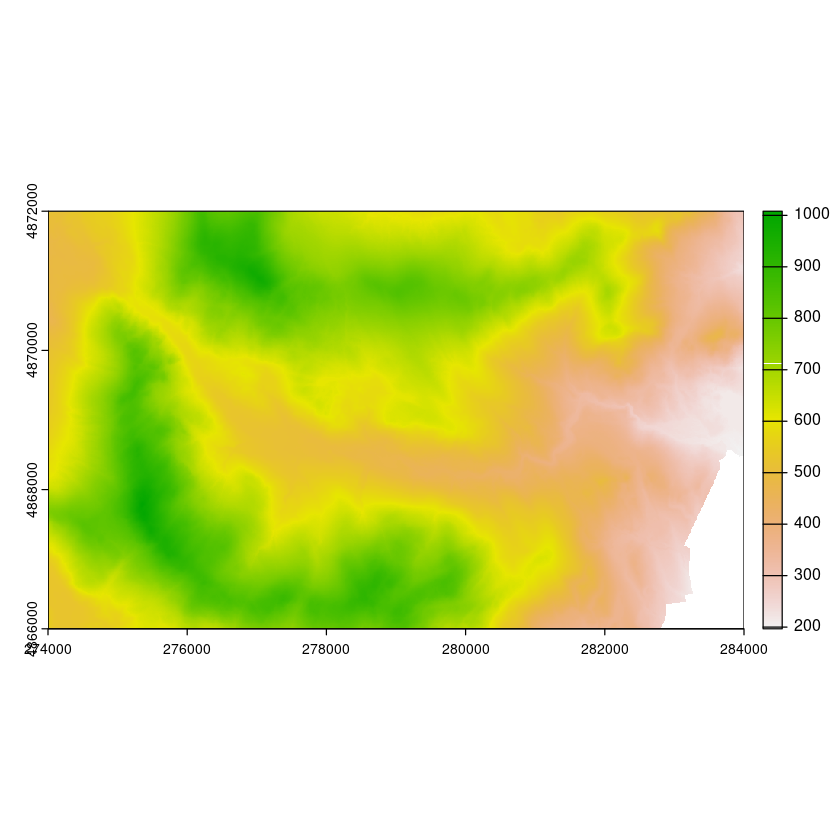

In [32]:

#################### Watershed & DEM ########################
hb <- vect("WetlandUplandGradient/data/hbef_wsheds/hbef_wsheds.shp")
hbdem <- rast("WetlandUplandGradient/data/dem1m.tif")
plot(hbdem)

[1] "ATTRIBUTE"  "WETLAND_TY" "ACRES"      "Shape_Leng" "Shape_Area"

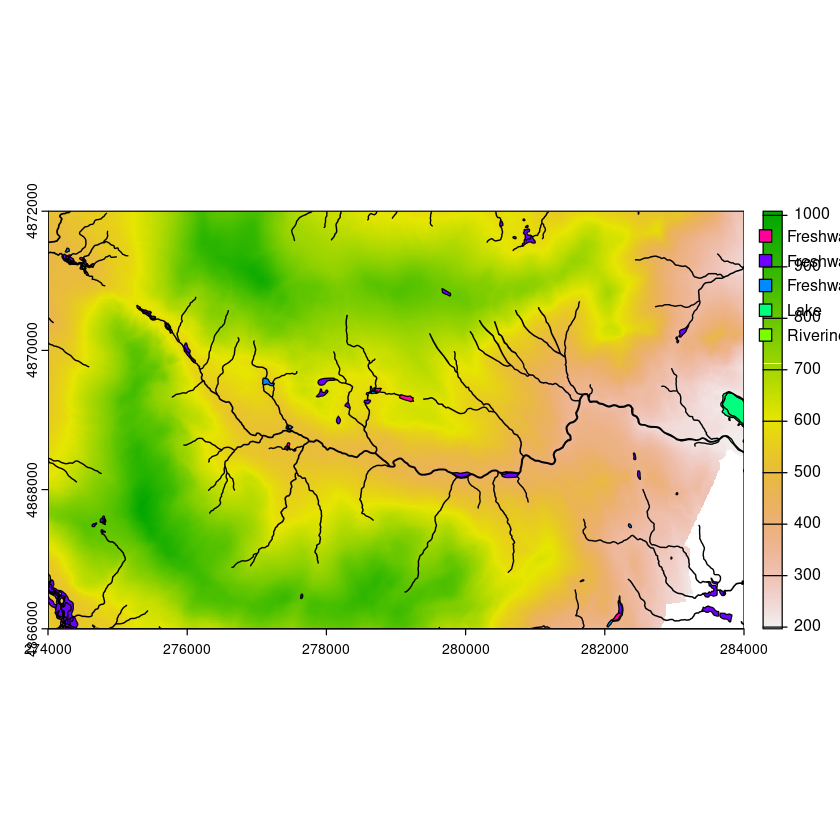

In [33]:
#################### NWI Wetlands ########################
nwi <- vect("WetlandUplandGradient/data/HU8_01070001_Watershed/HU8_01070001_Wetlands.shp") |> project("EPSG:26919")
hbnwi <- nwi |> crop(ext(hbdem)) 
names(hbnwi)
plot(hbdem)
plot(hbnwi, "WETLAND_TY", type = "classes", add = T)

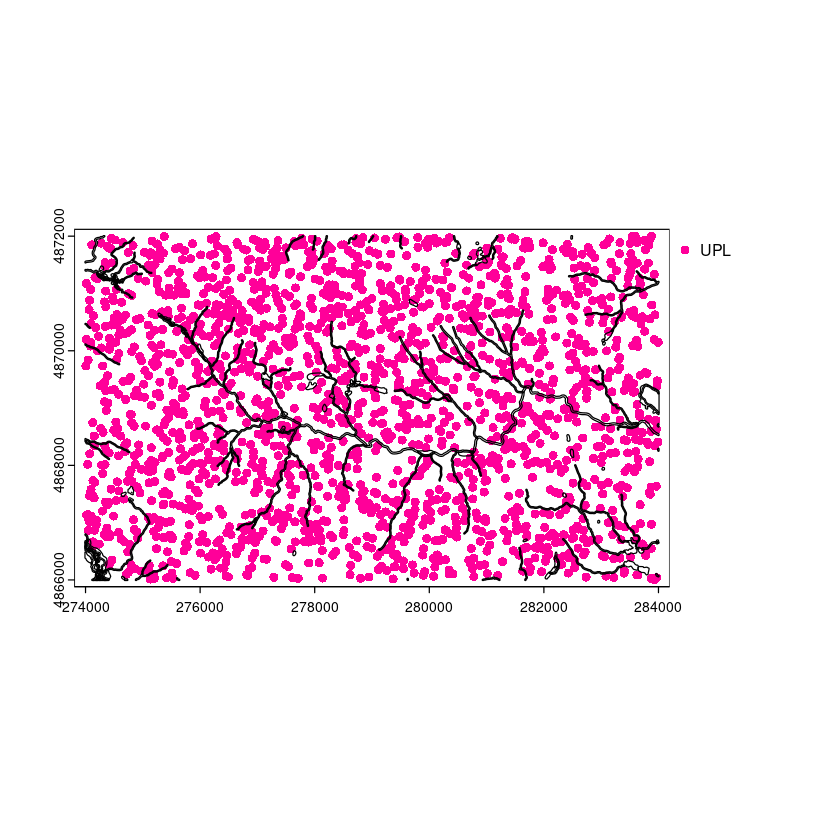

In [11]:
#################### Get training data - upland points #################### 

set.seed(11)
randupl <- spatSample(hbdem, 2000, as.points = TRUE, xy = TRUE)

hbnwi_buff <- buffer(hbnwi, 10) # buffer to remove potential wet areas

hbupl_pts <- terra::mask(randupl, hbnwi_buff, inverse = T) |> 
    mutate(class = "UPL") |>
    select(-dem1m)

plot(hbupl_pts, "class", type = "classes")
lines(hbnwi_buff)

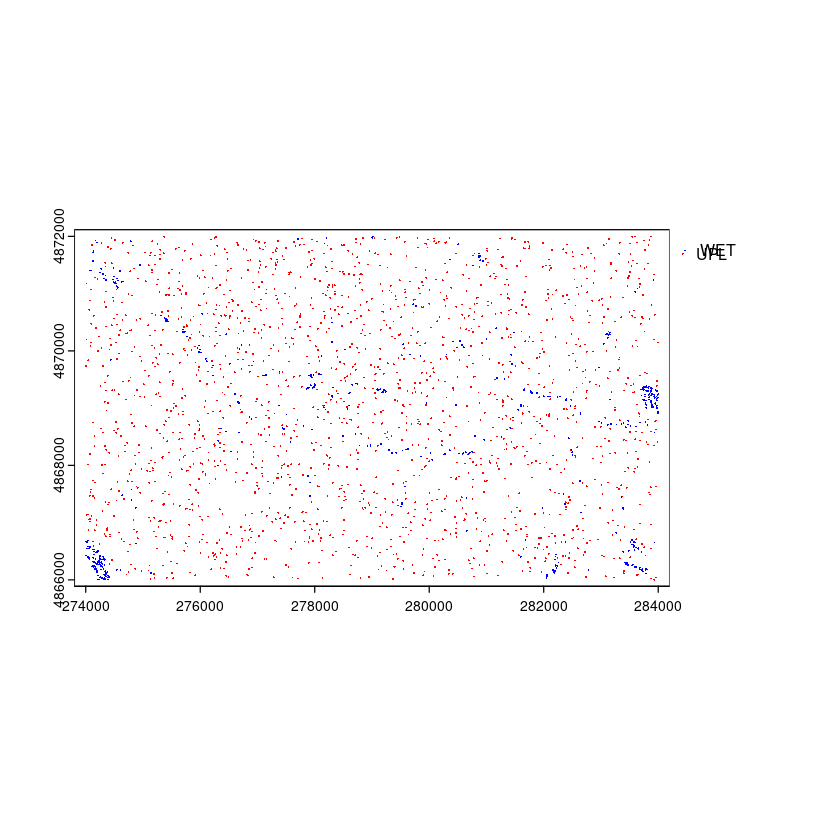

In [12]:
#################### Get training data - wetland upland points #################### 

hbwet_pts <- spatSample(hbnwi, size = 500) |> 
    mutate(class = "WET") |>
    select(class)

plot(hbwet_pts, "class" ,type = "classes", col = "blue", cex = 0.2)
plot(hbupl_pts, "class", type = "classes", col = "red", cex = 0.2, add = T)

Warning message in x@cpp$write(filename, layer, filetype, insert[1], overwrite[1], :
“GDAL Message 6: dataset WetlandUplandGradient/data/derived_data/hbpts_raw.gpkg does not support layer creation option ENCODING”


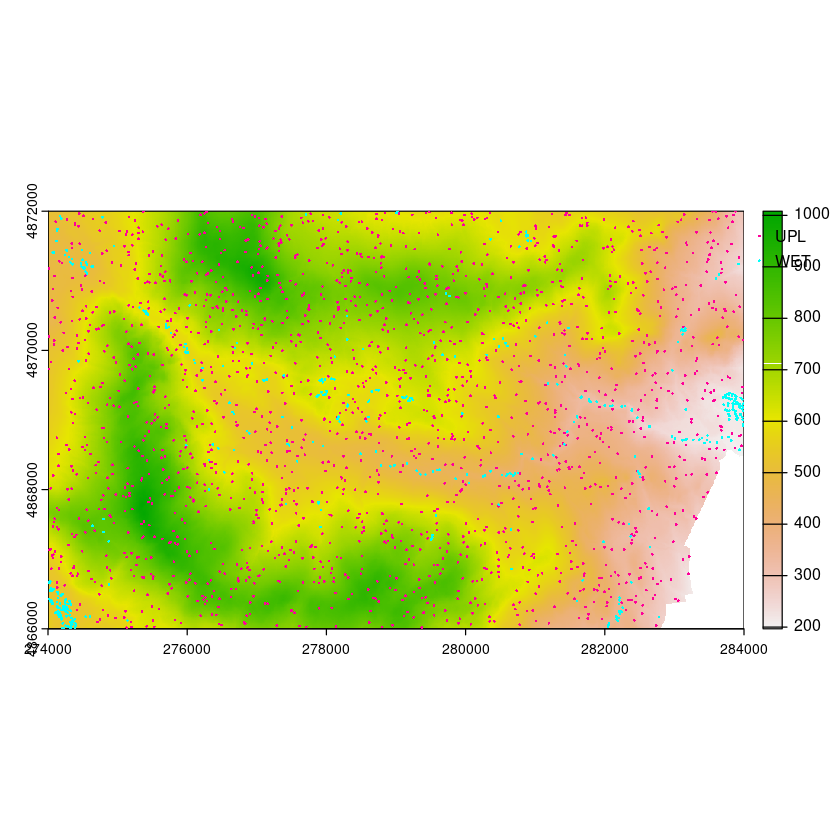

In [14]:
#################### Combine wetland and upland points #################### 

hbpts_all <- rbind(hbupl_pts, hbwet_pts) 
hbpts_ext <- terra::extract(hbdem, hbpts_all, bind = T) 
hbpts <- hbpts_ext |> dplyr::filter(!is.na(dem1m))
writeVector(hbpts, "WetlandUplandGradient/data/derived_data/hbpts_raw.gpkg", overwrite=TRUE)

plot(hbdem) 
plot(hbpts, "class", type = "classes", cex = 0.3, add = T)


In [15]:
#################### Make multiscale terrain metrics #################### 

hbslp_3 <- SlpAsp(hbdem, w = c(3,3), metrics = "slope", filename = "WetlandUplandGradient/data/derived_data/hbslp_3.tif", overwrite = T)

hbslp_27 <- SlpAsp(hbdem, w = c(27,27), metrics = "slope", filename = "WetlandUplandGradient/data/derived_data/hbslp_27.tif", overwrite = T)

hbslp_81 <- SlpAsp(hbdem, w = c(81,81), metrics = "slope", filename = "WetlandUplandGradient/data/derived_data/hbslp_81.tif", overwrite = T)


In [ ]:
# hbtpi_3 <- TPI(hbdem, w = c(3,3), 
#                shape="rectangle", stand="none", na.rm = TRUE, 
#                filename = "WetlandUplandGradient/data/derived_data/hbtpi_3.tif", overwrite = T)
# 
# hbtpi_27 <- TPI(hbdem, w = c(27,27), 
#                 shape="rectangle", stand="none", na.rm = TRUE,
#                 filename = "WetlandUplandGradient/data/derived_data/hbtpi_27.tif", overwrite = T)
# 
# hbtpi_81 <- TPI(hbdem, w = c(81,81), 
#                 shape="rectangle", stand="none", na.rm = TRUE,
#                 filename = "WetlandUplandGradient/data/derived_data/hbtpi_81.tif", overwrite = T)
# 

In [ ]:
# hbcurv_3 <- Qfit(hbdem, w = c(3,3), 
#                  metrics = c("meanc", "profc", "planc"), unit = "degrees", na.rm = TRUE,
#                  filename = "WetlandUplandGradient/data/derived_data/hbcurv_3.tif", overwrite = T)
# 
# hbcurv_27 <- Qfit(hbdem, w = c(27,27), 
#                   metrics = c("meanc", "profc", "planc"), unit = "degrees", na.rm = TRUE,
#                   filename = "WetlandUplandGradient/data/derived_data/hbcurv_27.tif", overwrite = T)
# 
# hbcurv_81 <- Qfit(hbdem, w = c(81,81), 
#                   metrics = c("meanc", "profc", "planc"), unit = "degrees", na.rm = TRUE,
#                   filename = "WetlandUplandGradient/data/derived_data/hbcurv_81.tif", overwrite = T)

In [22]:
#################### Multiscale terrain metrics already made #################### 

hbslp_3 <- rast("WetlandUplandGradient/data/derived_data/hbslp_3.tif")
hbslp_27<- rast("WetlandUplandGradient/data/derived_data/hbslp_27.tif")
hbslp_81<- rast("WetlandUplandGradient/data/derived_data/hbslp_81.tif")
hbcurv_3<- rast("WetlandUplandGradient/data/derived_data/hbcurv_3.tif")
hbcurv_27<- rast("WetlandUplandGradient/data/derived_data/hbcurv_27.tif")
hbcurv_81<- rast("WetlandUplandGradient/data/derived_data/hbcurv_81.tif")
hbtpi_3<- rast("WetlandUplandGradient/data/derived_data/hbtpi_3.tif")
hbtpi_27<- rast("WetlandUplandGradient/data/derived_data/hbtpi_27.tif")
hbtpi_81<- rast("WetlandUplandGradient/data/derived_data/hbtpi_81.tif")


In [23]:
#################### Stack multiscale terrain metrics and extract to training points #################### 

super_stack <- c(hbslp_3, hbslp_27, hbslp_81, 
                 hbcurv_3, hbcurv_27, hbcurv_81,
                 hbtpi_3, hbtpi_27, hbtpi_81)

hbpts_extract <- hbpts |> terra::extract(x = super_stack, bind = TRUE, xy = TRUE) |>
    drop_na()
names(hbpts_extract) <- (c("class", "dem", "slp_3", "slp_27", "slp_81", 
                           "meancurv_3", "prof_curv_3", "plan_curv_3",
                           "meancurv_27", "prof_curv_27", "plan_curv_27",
                           "meancurv_81", "prof_curv_81", "plan_curv_81",
                           "tpi_3", "tpi_27", "tpi_81", "x", "y"))
hbpts_extract$class <- as.factor(hbpts_extract$class)

#writeVector(hbpts_extract, "UplandWetlandGradient/data/derived_data/hbpts_hydrog_extract.gpkg", overwrite = TRUE)

In [24]:
#################### Split training points into training and testing #################### 

set.seed(11)

hbpts_exdf <- as.data.frame(hbpts_extract)

# Validation Set 
train.index <- as.vector(sample(c(1:nrow(hbpts_exdf)), 0.7*nrow(hbpts_exdf), replace=F))

train <- hbpts_exdf[train.index, c("class", "dem", "slp_3", "slp_27", "slp_81", 
                                   "meancurv_3", "prof_curv_3", "plan_curv_3",
                                   "meancurv_27", "prof_curv_27", "plan_curv_27",
                                   "meancurv_81", "prof_curv_81", "plan_curv_81",
                                   "tpi_3", "tpi_27", "tpi_81")]

test <- hbpts_exdf[-train.index, c("class", "dem", "slp_3", "slp_27", "slp_81", 
                                   "meancurv_3", "prof_curv_3", "plan_curv_3",
                                   "meancurv_27", "prof_curv_27", "plan_curv_27",
                                   "meancurv_81", "prof_curv_81", "plan_curv_81",
                                   "tpi_3", "tpi_27", "tpi_81")]

Confusion Matrix and Statistics

          Reference
Prediction  UPL  WET
       UPL 1270    0
       WET    0  306
                                     
               Accuracy : 1          
                 95% CI : (0.9977, 1)
    No Information Rate : 0.8058     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.8058     
         Detection Rate : 0.8058     
   Detection Prevalence : 0.8058     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : UPL        
                                     

Confusion Matrix and Statistics

          Reference
Prediction UPL WET
       UPL 549  18
       WET   9 100
                                          
               Accuracy : 0.9601          
                 95% CI : (0.9424, 0.9735)
    No Information Rate : 0.8254          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8571          
                                          
 Mcnemar's Test P-Value : 0.1237          
                                          
            Sensitivity : 0.9839          
            Specificity : 0.8475          
         Pos Pred Value : 0.9683          
         Neg Pred Value : 0.9174          
             Prevalence : 0.8254          
         Detection Rate : 0.8121          
   Detection Prevalence : 0.8388          
      Balanced Accuracy : 0.9157          
                                          
       'Positive' Class : UPL             
                              

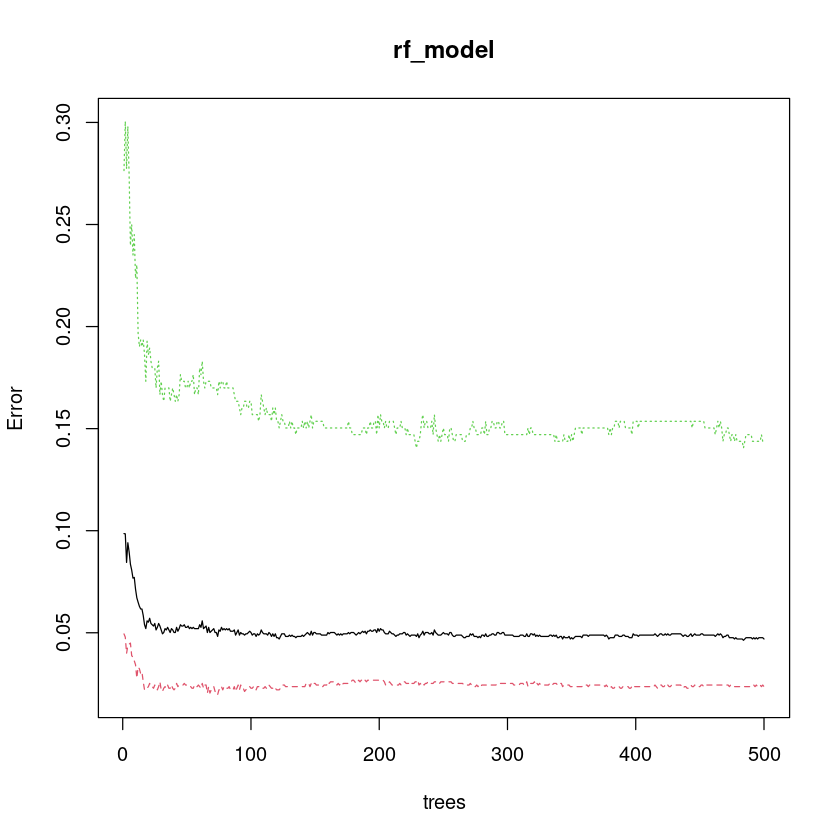

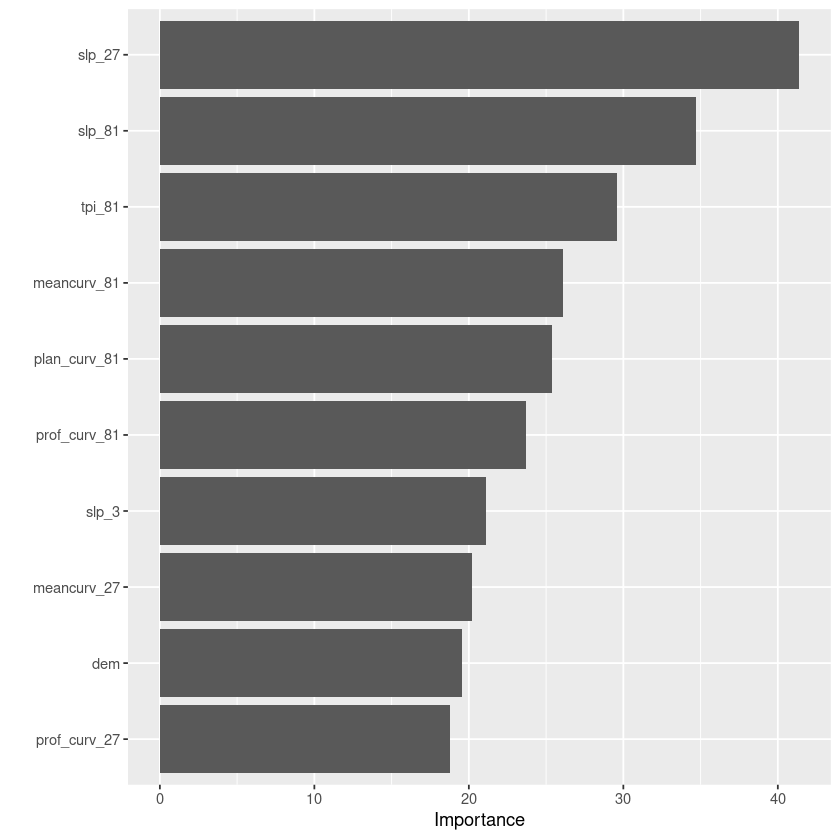

In [27]:
#################### Run random forest on training data #################### 

rf_model <- randomForest((class) ~ .,
                         ntree = 500, na.action = na.omit,
                         importance = TRUE, data = train)
plot(rf_model)

rf.test <- predict(rf_model, newdata = test, type = "response")
rf.train <- predict(rf_model, newdata = train)
caret::confusionMatrix(rf.train, train$class)
caret::confusionMatrix(rf.test, test$class)
vip::vip(rf_model)

In [29]:
#################### Adjust variable names and predict random forest to raster stack #################### 

pred_stack <- c(hbdem, super_stack)


names(pred_stack) <- (c("dem", "slp_3", "slp_27", "slp_81", 
                        "meancurv_3", "prof_curv_3", "plan_curv_3",
                        "meancurv_27", "prof_curv_27", "plan_curv_27",
                        "meancurv_81", "prof_curv_81", "plan_curv_81",
                        "tpi_3", "tpi_27", "tpi_81"))

hbwip <- predict(pred_stack, rf_model, type = "prob", filename = "WetlandUplandGradient/data/derived_data/hbwip_hydrog.tif", overwrite = TRUE)

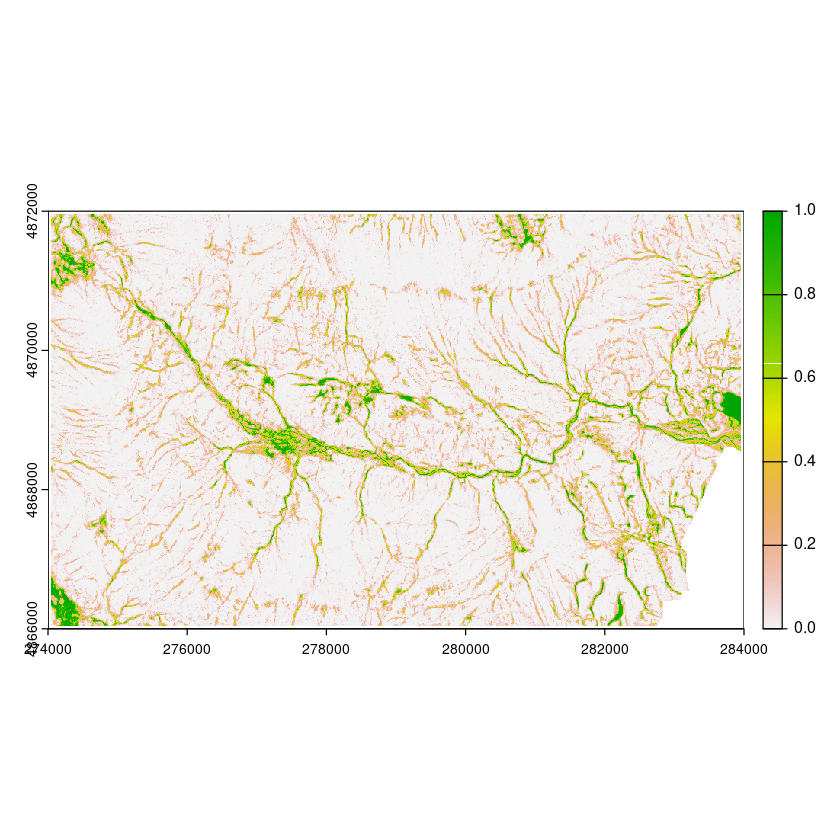

In [30]:
hbwip <- rast("WetlandUplandGradient/data/derived_data/hbwip_hydrog.tif")
plot(hbwip$WET)